In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as  plt

# Kinematics

Kinematics model studies the motion of bodies without considering forces and inertia of the robot. Having kinematics model is useful because allows us to compute the pose of the robot after applying a sequence of actions (e.g., motor commands) from a given initial pose, which is known as *forward kinematics*. The inverse problem, which is to compute the sequence of actions that will move the robot to a target pose from a given initial pose is called *inverse kinematics*. We have seen and derived the kinematics model of the Duckiebot in class, now let's see how we can actually use this model to do both forward and inverse kinematics.

# I: Forward kinematics

Given the kinematics model of the robot, we can write a function that simulates driving. 

How can we compute the pose of the robot after applying an action (e.g., by setting the left and right turning rates) for 1 time step, given the pose of the robot at the current time step?

Let's first consider the case when the left and right turning rates are the same. In this case, our robot will just move in a straight line and the instantaneous center of curvature (ICC) is not defined. So, what we need to do is to convert both turning velocity $v_r$ and $v_l$ into the body velocity $v_{A}$ and compute how much the robot will move if we apply this velocity for a fixed time step $dt$:

$$
\begin{bmatrix}
x \\
y
\end{bmatrix} = 
\begin{bmatrix}
x + v_{A}\cos(\theta)dt \\
y + v_{A}\sin(\theta)dt 
\end{bmatrix},
$$

where $v_{A} = 0.5(v_r + v_l)$. Note that, if we are given the turning rates $\psi_r$ and $\psi_l$ of the wheels instead of turning velocities, then we need to convert them into turning velocities. We can do this via $v_{r/l} = \psi_{r/l} 2 \pi r$, where $r$ denotes the radius of the wheels.

The second case is when the left and right turning rates are not the same. In this case, our robot will move in an arc that follows the ICC. To compute the location of the ICC, let's recall the equations that we derived in class to compute the distance from the robot to the ICC (i.e., $d$):

$$
d = L \frac{v_r + v_l}{v_r - v_l}
$$

As illustrated in the figure below, we can compute the location of the ICC via:

$$
\begin{bmatrix}
ICC_x \\
ICC_y
\end{bmatrix} = 
\begin{bmatrix}
x - d \sin(\theta) \\
y + d \cos(\theta) 
\end{bmatrix},
$$

<figure>
  <div style="text-align:center;">
  <img src="assets/compute_icc.png">
  <figcaption>Illustration of the ICC. Knowing $\theta$ and $d$ allows us to compute where the location of the ICC.</figcaption>
  </div>
</figure>

Once we know ICC, we want to know where the robot will end up on the curvature after applying $v_r$ and $v_l$ for one time step $dt$. Since we know $\dot{\theta} = \frac{0.5(v_r - v_l)}{L}$, we can compute the angular displacement of the robot after one time step (i.e., $\theta_{d} = \dot{\theta}dt$), which allows us to compute the new location of the robot. In below implementation, I chose to do things in a frame centered at the ICC where the $x$-axis points towards the robot, because it allows me to easily compute the new location of the robot in this frame (note that this is NOT the only approach to implement the forward kinematics!):

$$
\begin{bmatrix}
x^{ICC}_{new} \\
y^{ICC}_{new}
\end{bmatrix} = 
\begin{bmatrix}
d \cos(\theta_d) \\
d \sin(\theta_d) 
\end{bmatrix}
$$

Once we have $x^{ICC}_{new}$ and $y^{ICC}_{new}$, we can convert them to the global frame by multiplying the homogeneous transformation matrix of the ICC frame that we defined above with the transformation matrix from the ICC to $(x^{ICC}_{new}, y^{ICC}_{new})$.

<figure>
  <div style="text-align:center;">
  <img src="assets/compute_xy_new.png">
  <figcaption>Here, $\theta_d$ denotes the angular displacement as a result of applying $\dot{\theta}$ for one time step, and the green dot represents the new location of the robot on the curvature.</figcaption>
  </div>
</figure>

Now let's take a look at the implementation.

In [2]:
def get_next_pose(icc_pos, d, cur_theta, theta_displacement):
    """
    Compute the new next position in global frame
    Input:
        - icc_pos: numpy array of ICC position [x,y] in global frame
        - d: distance from robot to the center of curvature
        - cur_theta: current yaw angle in radian (float)
        - theta_displacement: the amount of angular displacement if we apply w for 1 time step
    Return:
        - next_position:
        - next_orientation:
    """
    
    # First, let's define the ICC frame as the frame centered at the location of ICC
    # and oriented such that its x-axis points towards the robot
    
    # Compute location of the point where the robot should be at (i.e., q)
    # in the frame of ICC.
    x_new_icc_frame = d * np.cos(theta_displacement)
    y_new_icc_frame = d * np.sin(theta_displacement)
    
    # Build transformation matrix from origin to ICC
    T_oc_angle = -(np.deg2rad(90) - cur_theta) # 
    icc_x, icc_y = icc_pos[0], icc_pos[1]
    T_oc = np.array([
        [np.cos(T_oc_angle), -np.sin(T_oc_angle), icc_x],
        [np.sin(T_oc_angle), np.cos(T_oc_angle), icc_y],
        [0, 0, 1]
    ]) # Transformation matrix from origin to the ICC
    
    # Build transformation matrix from ICC to the point where the robot should be at (i.e., q)
    T_cq = np.array([
        [1, 0, x_new_icc_frame],
        [0, 1, y_new_icc_frame],
        [0, 0, 1]
    ]) # Transformation matrix from ICC to the point where the robot should be at (i.e., q)
    
    # Convert the local point q to the global frame
    T_oq = np.dot(T_oc, T_cq) # Transformation matrix from origin to q
    
    next_position = np.array([T_oq[0,2], T_oq[1,2]])
    next_orientation = np.degrees(cur_theta) + np.degrees(theta_displacement)
    return next_position, next_orientation


def drive(cur_pos, cur_angle, left_rate, right_rate, wheel_dist, wheel_radius, dt):
    """
    Input:
        - cur_pos: numpy array of current position [x,y] in global frame
        - cur_angle: current yaw angle in degree (float)
        - left_rate: turning rate of the left wheel in turns/sec(float)
        - right_rate: turning rate of the right wheel in turns/sec (float)
        - wheel_dist: distance between left and right wheels in meters (i.e., 2L) (float)
        - wheel_radius: radius of the wheels in meters (i.e., R) (float)
        - dt: time step (float)
    Return:
        - next_position: numpy array of next position [x,y] in global frame
        - next_orientation: next yaw angle ()
    """
    
    # Convert angle to radian and rename some variables
    cur_theta = np.deg2rad(cur_angle)
    l = wheel_dist
    
    # Convert turning rate (turns/sec) into (m/sec)
    # Note: the amount of distance traveled by 1 wheel revolution
    # is equal to its circumference (i.e., 2 * pi * radius)
    Vl = left_rate * 2. * np.pi * wheel_radius
    Vr = right_rate * 2. * np.pi * wheel_radius

    # If the wheel velocities are the same, then there is no rotation
    if Vl == Vr:
        v = Vl = Vr
        new_x = cur_pos[0] + dt * v * np.cos(cur_theta)
        new_y = cur_pos[1] + dt * v * np.sin(cur_theta)
        cur_pos = np.array([new_x, new_y])
        cur_angle = cur_angle # does not change since we are moving straight
        return cur_pos, cur_angle

    # Compute the angular rotation (i.e., theta_dot) velocity about the ICC (center of curvature)
    w = (Vr - Vl) / l
    
    # Compute the velocity (i.e., v_A)
    v = (Vr + Vl) / 2. 
    
    # Compute the distance from robot to the center of curvature (i.e., d)
    d = v / w 
    
    # Compute the amount of angular displacement if we apply w for 1 time step
    theta_displacement = w * dt 

    # Compute location of ICC in global frame
    icc_x = cur_pos[0] - d * (np.sin(cur_theta)) 
    icc_y = cur_pos[1] + d * (np.cos(cur_theta))
    icc_pos = np.array([icc_x, icc_y])
    
    # Compute next position and orientation given cx, cy, d, cur_theta, and theta_displacement
    next_position, next_orientation = get_next_pose(icc_pos, d, cur_theta, theta_displacement)
    
    return next_position, next_orientation

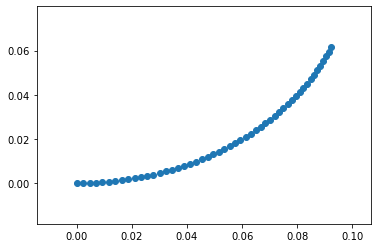

In [3]:
# Simulate driving

num_steps = 50
cur_pos = (0,0)
cur_angle = 0
positions = [cur_pos]
orientations = [cur_angle]
dt = 0.1 # time step in seconds
wheel_dist = 0.2 # distance between left and right wheels in meters, i.e., 2L
wheel_radius = 0.03 # radius of the wheels in meters, i.e., R

for _ in range(num_steps):
    left_rate = 0 # in turns/sec
    right_rate = 0.25 # in turns/sec
    cur_pos, cur_angle = drive(cur_pos, cur_angle, left_rate, right_rate, wheel_dist, wheel_radius, dt)
    positions.append(cur_pos)
    orientations.append(cur_angle)

# Plot resulting trajectory
xs, ys = zip(*positions)
plt.scatter(xs,ys)
plt.show()

# II: Simple inverse kinematics

Now, let's do some simple inverse kinematics! Consider a Duckiebot at $x = -3$m, $y = 2$m and $\theta = 45$ degrees. If the goal is to reach $x = 0$m, $y = 2$m and $\theta = -45$ degrees in exactly 10 seconds (with $dt = 0.1$) by applying the same action for the duration, can we compute the wheels' left and right turning rates (in turns per second) to achieve this?

Hint: since we are applying the same action for the duration, the robot will move in a circular trajectory.

<figure>
  <div style="text-align:center;">
  <img src="assets/inverse_kinematics_hint.png">
  </div>
</figure>

In [4]:
start_pos = np.array([-3, 2])
cur_angle = 45
end_pos = np.array([0, 2])
end_angle = -45
wheel_dist = 0.2     
wheel_radius = 0.03
dt = 0.1
num_steps = 100

# One possible solution is:
s = ... # TODO
d = ... # TODO
theta_d = ... # TODO in radian
w = ... # TODO angular velocity
v_l = ... # TODO left wheel velocity
v_r = ... # TODO right wheel velocity
left_rate = ... # TODO in turns/sec
right_rate = ... # TODO in turns/sec

print(left_rate, right_rate)

Ellipsis Ellipsis


correct answer: [1.8511002862997026 1.6844336196330356]

In [5]:
# Test drive
cur_pos = start_pos
cur_angle = 45
positions = [cur_pos]
orientations = [cur_angle]
for _ in range(num_steps):
    cur_pos, cur_angle = drive(cur_pos, cur_angle, left_rate, right_rate, wheel_dist, wheel_radius, dt)
    positions.append(cur_pos)
    orientations.append(cur_angle)

# Plot resulting trajectory
xs, ys = zip(*positions)
plt.scatter(xs,ys)
plt.show()

# Print end pose (should be [0, 2] and -45)
print(cur_pos.astype('int'), cur_angle.astype('int'))

TypeError: unsupported operand type(s) for *: 'ellipsis' and 'float'